### Fonctions d'activation
Nous allons commencer par définir les fonctions d'activations ainsi que leurs dérivées

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

def sigmoid(t):
    # Fonction d'activation sigmoïde
    return 1 / (1 + np.exp(-t))

def sigmoid_prime(t):
    # Dérivée de la fonction sigmoïde
    return sigmoid(t) * (1 - sigmoid(t))

def relu(t):
    # Fonction Relu
    return np.maximum(0,t)

def relu_prime(t):
    for i in range(len(t)):
        if t[i]>0 : t[i] = 1
        else: t[i] = 0 # on considère que pour t=0, relu'(t)=0
    return t
    
def identite(t):
    return t

def identite_prime(t):
    return 1

### Classe Réseau de neurones
Nous allons ici créer la classe ReseauNeurones

In [121]:
"""
    Entrée : la taille du vecteur d'entrée
    Sortie : une instance de réseau de neurones
"""

class ReseauNeurones(object):

    def __init__(self, taille):
        # self.taille est la taille du vecteur d'entrée
        # Dans chaque couche, on génère un nombre aléatoire de neurones
    
        self.a0 = np.array([[]]) # Initialisation de l'activité a0 par un tableau vide
        self.y = 0.0
        # Vecteur de poids et biais de la couche 1
        self.w1 = np.random.randn(random.randint(2, 5), taille)
        self.b1 = np.random.randn(self.w1.shape[0], 1)
        self.z1, self.a1 = np.array([[]]), np.array([[]]) #initialisation de l'activité
        
        # Vecteur de poids et biais de la couche 2
        self.w2 = np.random.randn(random.randint(2, 4), self.w1.shape[0]) # self.w1.shape[0] renvoie le nombre de ligne de w1
        self.b2 = np.random.randn(self.w2.shape[0], 1) # self.w1.shape[0] renvoie le nombre de ligne de w1
        self.z2, self.a2 = np.array([[]]), np.array([[]])
        
        # Vecteur de poids et biais de la couche 3
        self.w3 = np.random.randn(random.randint(2, 3), self.w2.shape[0]) ## self.taille - 3 est un choix arbitraire
        self.b3 = np.random.randn(self.w3.shape[0], 1)
        self.z3, self.a3 = np.array([[]]), np.array([[]])
        
        # Dernière couche
        self.w4 = np.random.randn(1, self.w3.shape[0]) # un seul neurone
        self.b4 = np.random.randn(self.w4.shape[0], 1)
        self.z4, self.a4 = np.array([[]]), np.array([[]])
        
        # Ces varibales nous seront utiles pour la suite
        # On augmente les dimensions des tableaux pour pouvoir utiliser la formule de recurrence de la prop. avant
        self.neurones = [np.array([[]]), self.w1, self.w2, self.w3, self.w4]
        self.biais = [np.array([[]]), self.b1, self.b2, self.b3, self.b4]
        self.preac = [np.array([[]]), self.z1, self.z2, self.z3, self.z4]
        self.activ = [self.a0, self.a1, self.a2, self.a3, self.a4]
        
        """
        Remarque : avec les quatres listes ci-dessus, on aurait pu se passer de definir les a_i, w_i,
        b_i et z_i. Mais pour des raisons de clarté et de compréhensibilité, nous l'avons fait.
        """
        
        self.cout = [] # Va servir à stocker le coût lors de la déscente de gradient
        
        self.gw1, self.gw2, self.gw3, self.gw4 = np.array([[]]), np.array([[]]), np.array([[]]), np.array([[]])
        self.gb1, self.gb2, self.gb3, self.gb4 = np.array([[]]), np.array([[]]), np.array([[]]), np.array([[]])
        
        self.grad_w = [np.array([[]]), self.gw1, self.gw2, self.gw3, self.gw4]
        self.grad_b = [np.array([[]]), self.gb1, self.gb2, self.gb3, self.gb4]

    def propagation_avant(self, X):
        # Propagation avant
        self.activ[0] = X # a0 = X // initialisation
        
        for i in range(1, len(self.neurones)-1):
            self.preac[i] = self.neurones[i].dot(self.activ[i-1])
            self.activ[i] = relu(self.preac[i]) #on a decidé d'utiliser la fonction relu
        
        # Dernière couche
        # l'indice -1 permet de recupérer le dernier élément d'un tableau
        self.preac[-1] = self.neurones[-1].dot(self.activ[-2])
        self.activ[-1] = sigmoid(self.preac[-1]) # on décide de faire de la classification 0/1
        #print(self.preac[-1], '\n\n', self.activ[-1]) # c'était un test
        
        self.y = float(self.activ[-1])  # Prédiction finale
        if self.y == 0.5:
            self.y = random.uniform(0.4, 0.6)
        #print('La prédiction est : {}'.format(self.y))
        return self.y

    def retropropagation(self, X, cible, taux=1):
        # Retropropagation du coût
        tmp = self.propagation_avant(X) # On récupère la prédiction de la propagation avant
        
        ga = 2*(tmp - cible) # Initialisation du gradient par rapport à y = a^L
        gz = ga * sigmoid_prime(self.preac[-1])
        self.grad_w[-1] = gz.dot(self.activ[-2].T) * taux
        self.grad_b[-1] = gz * taux
        
        ga = self.neurones[-1].T.dot(gz)
        
        for j in range(len(self.neurones)-2, 0, -1):
        
            gz = ga * relu_prime(self.preac[j])
            self.grad_w[j] = gz.dot(self.activ[j-1].T) * taux
            self.grad_b[j] = gz * taux
            ga = self.neurones[j].T.dot(gz)

    def pas_gradient(self, X, cible, etapes, taux):

        self.cout = [0 for k in range(etapes)]
        
        for etape in range(etapes):
            
            # On effectue une rétropropagation et on récupère les dérivées
            self.retropropagation(X, cible, taux)
            self.cout[etape] = (self.y - cible)**2
            
            # Mise à jour des W^i et des b^i
            for k in range(len(self.neurones)-1, 0, -1):
                self.neurones[k] = self.neurones[k] - self.grad_w[k]
                self.biais[k] = self.biais[k] - self.grad_b[k]
            
    def ajouter_couche(self, nb_neurones):
        # On ajoute la nouvelle couche à la fin, avant la dernière couche de prédiction
        
        dim = self.neurones[-2].shape[0] # On récupère le nbre de lignes de l'avant dernière matrice
        self.neurones.insert(-1, np.random.randn(nb_neurones, dim))
        self.biais.insert(-1, np.random.randn(nb_neurones, 1))
        
        # Mise à jour de la dernière couche
        self.neurones[-1] = np.random.randn(1, nb_neurones)
        return "Nouvelle couche ajoutée avec succès !"

### Nous allons maintenant utiliser notre RN pour résoudre le XOR (Exemple 1)

In [196]:
# Le vecteur d'entrée.
x = np.array([[0, 1], [1, 0], [1, 1], [0, 0]])

# La cible
y = np.array([[1], [1], [0], [0]])


# Initialisation des vecteurs de coûts et de prédiction
c = [[] for k in range(len(x))] # Va servir à observer l'évolution du coût
pred_y = [0 for o in range(len(x))] #Va servir à observer la prédiction

In [213]:
# On crée un RN qui prend en entrée un vecteur de taille 2
rn = ReseauNeurones(2)

for j in range(len(x)):
    print('\n*********************** tour : {} ***************************\n'.format(j+1))
    X = x[j].reshape(x[j].shape[0], 1)
    Y = y[j]
    rn.pas_gradient(X, Y, 1000, 0.01)
    c[j] = rn.cout
    pred_y[j] = rn.propagation_avant(X)


*********************** tour : 1 ***************************


*********************** tour : 2 ***************************


*********************** tour : 3 ***************************


*********************** tour : 4 ***************************



### Courbe d'évolution du coût

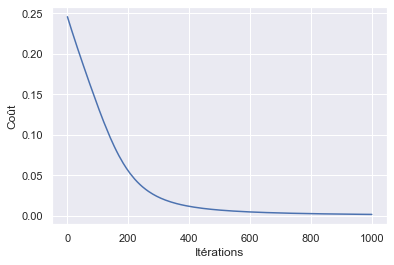

In [215]:
plt.plot(range(1000), c[0])
plt.ylabel('Coût')
plt.xlabel('Itérations')
plt.show()

### Affichage des prédictions

In [214]:
pred_y_binaire = [0 if i < 0.6 else 1 for i in pred_y]
pred_y

[0.9565115026406835,
 0.9654117319059852,
 0.049381101694851534,
 0.4222605164354328]

<AxesSubplot:xlabel='x', ylabel='y'>

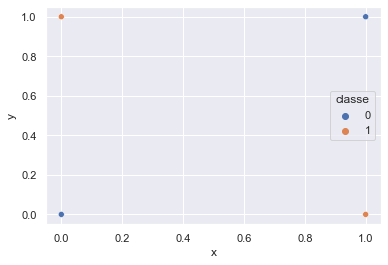

In [216]:
data_predic = pd.DataFrame({
    'x' : [0, 1, 1, 0],
    'y' : [1, 0, 1, 0],
    'classe' : pred_y_binaire})

sns.scatterplot(x="x", y="y", hue="classe", data=data_predic)

### Résolution du XOR (Exemple 2)

In [113]:
# On définit la fonction qui génère des 0/1
def formater(mat):
    for w in range(len(mat)):
        # Coordonnée 1
        if (mat[w][0] < 0.5):
            mat[w][0] = 0
        else: mat[w][0] = 1
        
        # Coordonnée 2
        if (mat[w][1] < 0.5):
            mat[w][1] = 0
        else: mat[w][1] = 1
    return mat

In [114]:
A = [[random.random(), random.random()] for i in range(1000)]
A

[[0.34728758291911843, 0.042718204873672505],
 [0.7509031218521044, 0.9185925484668581],
 [0.6441938309632026, 0.0647690316402566],
 [0.1334443398714672, 0.9348728601265273],
 [0.25605195854600715, 0.07510975480050053],
 [0.0835496033552473, 0.47497570326801064],
 [0.08544307862703215, 0.4319663572356296],
 [0.1616209041125437, 0.9807933722746505],
 [0.44198310740941393, 0.29348317706025984],
 [0.601054212584316, 0.8290923418436974],
 [0.988170261749071, 0.42382717971440464],
 [0.056031151914854194, 0.39906323449557124],
 [0.3065482101018321, 0.6520106080811355],
 [0.936612657600141, 0.3233663387664518],
 [0.28466484723192576, 0.9557925117857001],
 [0.4276675704679491, 0.8959220830530947],
 [0.9277069437961541, 0.061549063037292795],
 [0.8614777621075896, 0.8949740914271542],
 [0.8920109317536692, 0.07987841418334618],
 [0.10634746567581632, 0.9210761166907842],
 [0.0721247992916928, 0.4342625682922586],
 [0.08122255422369329, 0.29837081195240966],
 [0.20502719159257932, 0.577640279483

In [115]:
INPUT = np.array(formater(A))
INPUT

array([[0, 0],
       [1, 1],
       [1, 0],
       ...,
       [0, 0],
       [0, 1],
       [1, 0]])

In [116]:
# On définit la fonction xor
def xor(mat):
    out = []
    for y in range(len(mat)):
        if (sum(mat[y]) == 1):
            out.append([1])
        else: out.append([0])
    return out

In [117]:
OUTPUT = np.array(xor(INPUT))
OUTPUT

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [118]:
# Initialisation des vecteurs de coûts et de prédiction
EQM = [[] for k in range(len(INPUT))]
c = [[] for k in range(len(INPUT))] # Va servir à observer l'évolution du coût
pred_y = [0 for o in range(len(INPUT))] #Va servir à observer la prédiction

# On crée un RN qui prend en entrée un vecteur de taille 2
Reseau = ReseauNeurones(2)

for m in range(len(INPUT)):
    print('\n*********************** tour : {} ***************************\n'.format(m+1))
    X = INPUT[m].reshape(INPUT[m].shape[0], 1)
    Y = OUTPUT[m]
    Reseau.pas_gradient(X, Y, 1000, 0.01)
    pred_y[m] = Reseau.propagation_avant(X)
    c[m] = Reseau.cout
    EQM[m] = (pred_y[m] - Y)**2


*********************** tour : 1 ***************************


*********************** tour : 2 ***************************


*********************** tour : 3 ***************************


*********************** tour : 4 ***************************


*********************** tour : 5 ***************************


*********************** tour : 6 ***************************


*********************** tour : 7 ***************************


*********************** tour : 8 ***************************


*********************** tour : 9 ***************************


*********************** tour : 10 ***************************


*********************** tour : 11 ***************************


*********************** tour : 12 ***************************


*********************** tour : 13 ***************************


*********************** tour : 14 ***************************


*********************** tour : 15 ***************************


*********************** tour : 16 **************


*********************** tour : 129 ***************************


*********************** tour : 130 ***************************


*********************** tour : 131 ***************************


*********************** tour : 132 ***************************


*********************** tour : 133 ***************************


*********************** tour : 134 ***************************


*********************** tour : 135 ***************************


*********************** tour : 136 ***************************


*********************** tour : 137 ***************************


*********************** tour : 138 ***************************


*********************** tour : 139 ***************************


*********************** tour : 140 ***************************


*********************** tour : 141 ***************************


*********************** tour : 142 ***************************


*********************** tour : 143 ***************************


*********************** 


*********************** tour : 257 ***************************


*********************** tour : 258 ***************************


*********************** tour : 259 ***************************


*********************** tour : 260 ***************************


*********************** tour : 261 ***************************


*********************** tour : 262 ***************************


*********************** tour : 263 ***************************


*********************** tour : 264 ***************************


*********************** tour : 265 ***************************


*********************** tour : 266 ***************************


*********************** tour : 267 ***************************


*********************** tour : 268 ***************************


*********************** tour : 269 ***************************


*********************** tour : 270 ***************************


*********************** tour : 271 ***************************


*********************** 


*********************** tour : 386 ***************************


*********************** tour : 387 ***************************


*********************** tour : 388 ***************************


*********************** tour : 389 ***************************


*********************** tour : 390 ***************************


*********************** tour : 391 ***************************


*********************** tour : 392 ***************************


*********************** tour : 393 ***************************


*********************** tour : 394 ***************************


*********************** tour : 395 ***************************


*********************** tour : 396 ***************************


*********************** tour : 397 ***************************


*********************** tour : 398 ***************************


*********************** tour : 399 ***************************


*********************** tour : 400 ***************************


*********************** 


*********************** tour : 514 ***************************


*********************** tour : 515 ***************************


*********************** tour : 516 ***************************


*********************** tour : 517 ***************************


*********************** tour : 518 ***************************


*********************** tour : 519 ***************************


*********************** tour : 520 ***************************


*********************** tour : 521 ***************************


*********************** tour : 522 ***************************


*********************** tour : 523 ***************************


*********************** tour : 524 ***************************


*********************** tour : 525 ***************************


*********************** tour : 526 ***************************


*********************** tour : 527 ***************************


*********************** tour : 528 ***************************


*********************** 


*********************** tour : 643 ***************************


*********************** tour : 644 ***************************


*********************** tour : 645 ***************************


*********************** tour : 646 ***************************


*********************** tour : 647 ***************************


*********************** tour : 648 ***************************


*********************** tour : 649 ***************************


*********************** tour : 650 ***************************


*********************** tour : 651 ***************************


*********************** tour : 652 ***************************


*********************** tour : 653 ***************************


*********************** tour : 654 ***************************


*********************** tour : 655 ***************************


*********************** tour : 656 ***************************


*********************** tour : 657 ***************************


*********************** 


*********************** tour : 770 ***************************


*********************** tour : 771 ***************************


*********************** tour : 772 ***************************


*********************** tour : 773 ***************************


*********************** tour : 774 ***************************


*********************** tour : 775 ***************************


*********************** tour : 776 ***************************


*********************** tour : 777 ***************************


*********************** tour : 778 ***************************


*********************** tour : 779 ***************************


*********************** tour : 780 ***************************


*********************** tour : 781 ***************************


*********************** tour : 782 ***************************


*********************** tour : 783 ***************************


*********************** tour : 784 ***************************


*********************** 


*********************** tour : 899 ***************************


*********************** tour : 900 ***************************


*********************** tour : 901 ***************************


*********************** tour : 902 ***************************


*********************** tour : 903 ***************************


*********************** tour : 904 ***************************


*********************** tour : 905 ***************************


*********************** tour : 906 ***************************


*********************** tour : 907 ***************************


*********************** tour : 908 ***************************


*********************** tour : 909 ***************************


*********************** tour : 910 ***************************


*********************** tour : 911 ***************************


*********************** tour : 912 ***************************


*********************** tour : 913 ***************************


*********************** 

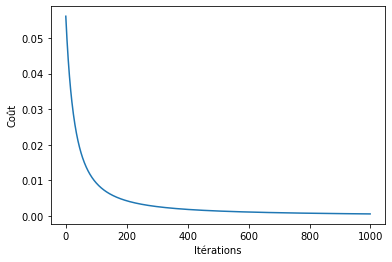

In [120]:
plt.plot(range(1000), c[1]) # On peut par exemple visualiser l'évolution du cout de la i^ème prédiction
plt.ylabel('Coût')
plt.xlabel('Itérations')
plt.show()

In [126]:
pred_y_binaire = [0 if i < 0.5 else 1 for i in pred_y]
pred_y_binaire

[1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,


In [122]:
# l'Erreur Quadratique Moyenne

Erreur = sum(EQM)/len(EQM)
print(float(Erreur))

0.08284436853699445


In [123]:
import sklearn.metrics
#On compare la valeur de l'erreur avec la sklearn.metrics.mean_squared_error

print(sklearn.metrics.mean_squared_error(OUTPUT, pred_y_binaire))
# c'est normal que l'erreur soit plus grande car on a attripué les valeurs
# 0 ou 1 selon que la prédiction est inférieure (ou supérieure) à 0.5

0.158


In [125]:
# la fonction sklearn.metrics.confusion_matrix permet d'évaluer la précision d'une classification

cm = sklearn.metrics.confusion_matrix(OUTPUT, pred_y_binaire, labels=[0, 1])
print(pd.DataFrame(cm,
                   index=['Cible : 0', 'Cible : 1'],
                   columns=['Prédiction : 0', 'Prédiction : 1']))

           Prédiction : 0  Prédiction : 1
Cible : 0             342             158
Cible : 1               0             500


## Classification de couleurs

Nous allons cette fois-ci utiliser notre réseau de neurones pour faire de la classification de couleur : nous avons en entrée un vecteur qui coutient le code RGB de la couleur bleue (et de quelques unes de ses dérivées). L'objectif est d'entrainer notre RN à pouvoir reconnaitre le bleu à partir de ces codes RGB.

Nous avons trouvé ces codes RGB sur le site suivant : http://jonasjacek.github.io/colors/.

### C'est quoi le code RGB ?

RGB (Red, Green and Blue) est un triplet (x,y,z) qui permet de désigner une couleur. chaque élément du triplet a une valeur comprise entre 0 et 255. Par exemple, le noir est désigné par (0,0,0) et le blanc par (255,255,255).

Pour en savoir plus, prière de consulter : https://fr.wikipedia.org/wiki/Rouge_vert_bleu.

In [128]:
# Vecteur qui contient 29 variantes de bleus
blue = [
        [0,0,128],
        [0,0,255],
        [0,0,95],
        [0,0,135],
        [0,0,175],
        [0,0,215],
        [0,0,255],
        [0,95,95],
        [0,95,135],
        [0,95,175],
        [0,95,215],
        [0,95,255],
        [0,135,175],
        [0,135,215],
        [0,135,255],
        [0,175,215],
        [0,175,255],
        [95,95,175],
        [95,95,215],
        [95,95,255],
        [95,135,215],
        [95,135,255],
        [95,175,215],
        [95,175,255],
        [95,215,255],
        [135,135,255],
        [135,175,255],
        [135,215,255],
        [175,215,255]
]

#On va utiliser 70% (20 codes) du vecteur pour l'entrainement et les 30% restant pour tester le RN
train_x = np.array([blue[j] for j in range(20)])
test_x = np.array([blue[k] for k in range(len(train_x), len(blue))])

train_y = np.array([1 for i in range(len(train_x))]) # On fait de la classification binaire : 1 = vrai

In [129]:
# On crée un RN qui prend en entrée un vecteur de taille 3
class_col = ReseauNeurones(3)

print('\t\tEntraînement\n')
for m in range(len(train_x)):
    print('Code RGB : ', m+1)
    X = train_x[m].reshape(train_x[m].shape[0], 1)
    Y = train_y[m]
    class_col.pas_gradient(X, Y, 1000, 0.01)

		Entraînement

Code RGB :  1
Code RGB :  2
Code RGB :  3
Code RGB :  4
Code RGB :  5
Code RGB :  6
Code RGB :  7
Code RGB :  8
Code RGB :  9
Code RGB :  10
Code RGB :  11
Code RGB :  12
Code RGB :  13
Code RGB :  14
Code RGB :  15
Code RGB :  16
Code RGB :  17
Code RGB :  18
Code RGB :  19
Code RGB :  20


In [130]:
print('\t\tTest\n')
for l in range(len(test_x)):
    W = test_x[l].reshape(test_x[l].shape[0], 1)
    pred = class_col.propagation_avant(W)
    # pred est compris entre 0 et 1. S'il est proche de 1, la prédiction est bonne.
    print('Prédiction {} : {}'.format(l+1, pred))

		Test

Prédiction 1 : 1.0
Prédiction 2 : 1.0
Prédiction 3 : 1.0
Prédiction 4 : 1.0
Prédiction 5 : 1.0
Prédiction 6 : 1.0
Prédiction 7 : 1.0
Prédiction 8 : 1.0
Prédiction 9 : 1.0


Notre réseau de neurones semble bien se comporter :)